# Aperiodic electrophysiological activity tracks spiking statistics between behavioral states
Sawyer Figueroa, Michael Preston, Bradley Voytek

# SfN 2023, Poster Panel 4
This notebook reproduces the figures from poster panel 4. Panel 4 investigates the relationship between spike-synchrony and aperiodic LFP activity. Comparisons are made between behavioral epochs.

Dataset: Allen Institute for Brain Science: Visual Coding - Neuropixels  
© 2015 Allen Institute for Brain Science. Allen Brain Atlas API. Available from: https://portal.brain-map.org/explore/circuits/visual-coding-neuropixels

## Set-up

### set paths

In [1]:
# set paths
PROJECT_PATH = "G:/Shared drives/visual_encoding" # shared results directory
MANIFEST_PATH = 'D:/datasets/allen_vc' # path to manifest file and local dataset

### imports

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy.stats as sts
import statsmodels.api as sm
import os

In [4]:
# custom imports
import sys
sys.path.append('../../')
from allen_vc.plots import plot_linregress
from allen_vc.utils import combine_spike_lfp_dfs, channel_medians, create_long_region_df
from allen_vc.stats import mixedLM

print("Imported!")

Imported!


### settings

In [5]:
# matplotlib and figure appearance settings
plt.style.use(f'../../stylelib/sfn_2023.mplstyle')
# COLORS = ["#7570b3", "#3FAA96", "#F39943"]

### load data

In [6]:
# load data for beahvior: running

# load spike data
running_spikes = pd.read_csv(f'{PROJECT_PATH}/data/spike_stats/region_metrics/spontaneous_running.csv').assign(behavior='running')

# load lfp data
running_lfp = pd.read_csv(f'{PROJECT_PATH}/data/lfp_data/params/psd/spontaneous_running/lfp_params.csv')


In [7]:
# load data for beahvior: stationary

# load spike data
stationary_spikes = pd.read_csv(f'{PROJECT_PATH}/data/spike_stats/region_metrics/spontaneous_stationary.csv').assign(behavior='stationary')

# load lfp data
stationary_lfp = pd.read_csv(f'{PROJECT_PATH}/data/lfp_data/params/psd/spontaneous_stationary/lfp_params.csv')


In [8]:
# load data for stim: natural_movie_one_more_repeats

# load spike data
movie_spikes = pd.read_csv(f'{PROJECT_PATH}/data/spike_stats/region_metrics/natural_movie_one_more_repeats.csv').assign(presentation='movie')

# load lfp data
movie_lfp = pd.read_csv(f'{PROJECT_PATH}/data/lfp_data/params/psd/natural_movie_one_more_repeats/lfp_params.csv')


In [9]:
# load data for stim: natural_movie_one_shuffled

# load spike data
shuffled_spikes = pd.read_csv(f'{PROJECT_PATH}/data/spike_stats/region_metrics/natural_movie_one_shuffled.csv').assign(presentation='shuffled')

# load lfp data
shuffled_lfp = pd.read_csv(f'{PROJECT_PATH}/data/lfp_data/params/psd/natural_movie_one_shuffled/lfp_params.csv')


## Main

### Regression plot: mean firing rate vs. broadband offset 

##### Spontaneous activity: model behavioral states (running and stationary) seperately  

In [12]:
# modify df_lfp - average over channels for each epoch within each session
running_lfp_i = running_lfp.groupby(['session', 'epoch_idx']).mean().reset_index().drop(columns=['chan_idx']).assign(behavior='running')
stationary_lfp_i = stationary_lfp.groupby(['session', 'epoch_idx']).mean().reset_index().drop(columns=['chan_idx']).assign(behavior='stationary')

# concatenate running and stationary epoch data
lfp_i = pd.concat([running_lfp_i, stationary_lfp_i])
units_i = pd.concat([running_spikes, stationary_spikes])

nans_i = lfp_i.merge(units_i, on=['session', 'epoch_idx', 'behavior'])

# eliminate 12 nan entries for lfp
behavior_df_i = nans_i[~nans_i['offset'].isna()]

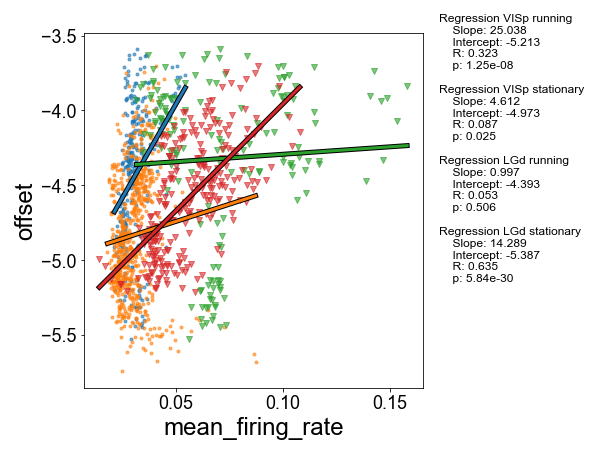

In [13]:
plot_linregress(behavior_df_i, 'mean_firing_rate', 'offset', group='behavior', multireg=True, show=True)

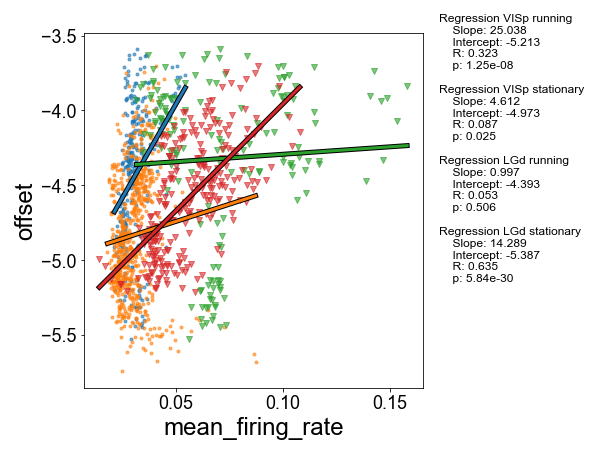

In [14]:
# remove clear outlier
behavior_df = behavior_df_i[behavior_df_i['mean_firing_rate'] > 0.01]

plot_linregress(behavior_df, 'mean_firing_rate', 'offset', group='behavior', multireg=True, show=True)

##### Passive viewing: model stimulus contexts (movie and shuffled) seperately; plot stationary epochs only

In [15]:
# modify df_lfp - average over channels for each epoch within each session
movie_lfp_i = movie_lfp.groupby(['session', 'epoch_idx']).mean().reset_index().drop(columns=['chan_idx']).assign(presentation='movie')
shuffled_lfp_i = shuffled_lfp.groupby(['session', 'epoch_idx']).mean().reset_index().drop(columns=['chan_idx']).assign(presentation='shuffled')

# concatenate movie and shuffled epoch data
lfp_i = pd.concat([movie_lfp_i, shuffled_lfp_i])
units_i = pd.concat([movie_spikes, shuffled_spikes])

nans_i = lfp_i.merge(units_i, on=['session', 'epoch_idx', 'presentation'])

# eliminate 5 nan entries for lfp
presentation_df = nans_i[~nans_i['offset'].isna()]

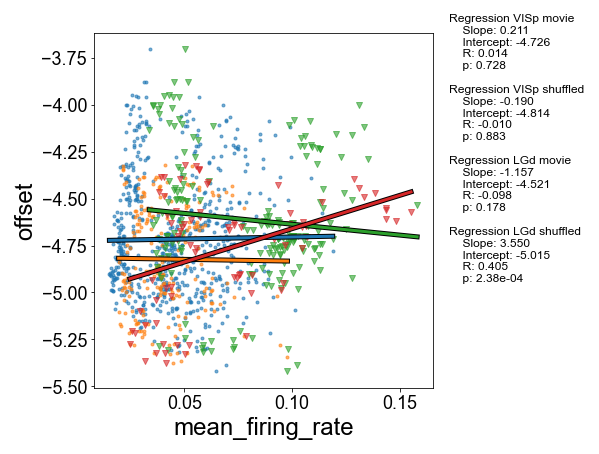

In [16]:
# section stationary epochs only for now
stationary_presentation_df = presentation_df[~presentation_df['running']]
plot_linregress(stationary_presentation_df, 'mean_firing_rate', 'offset', group='presentation', multireg=True, show=True)

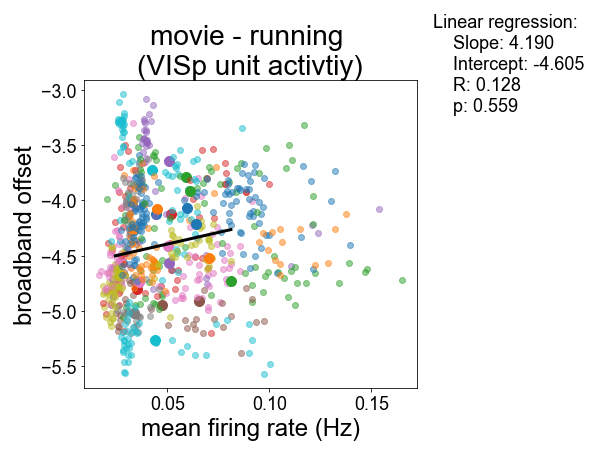

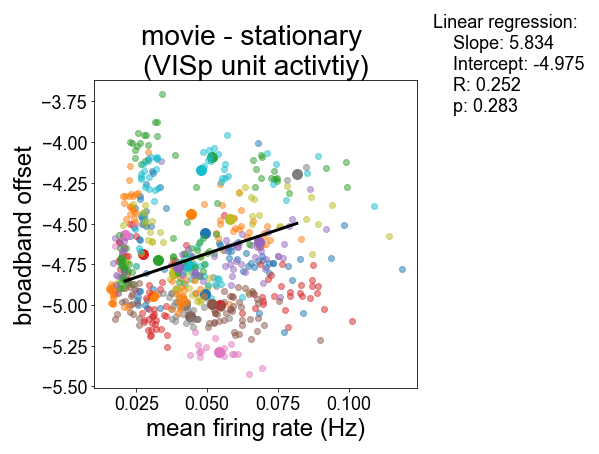

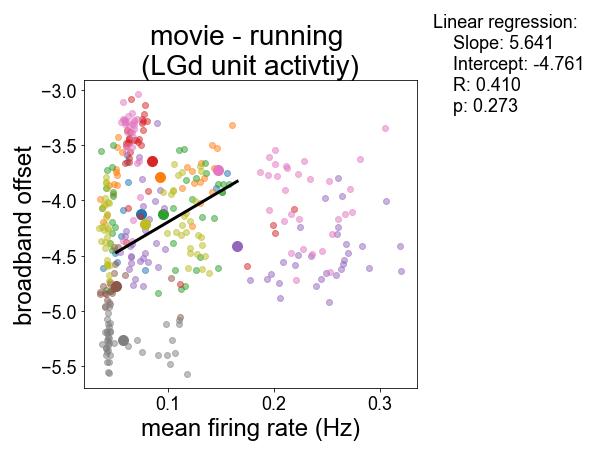

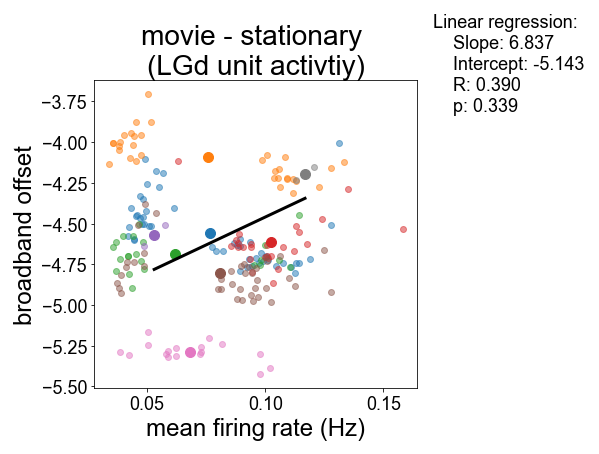

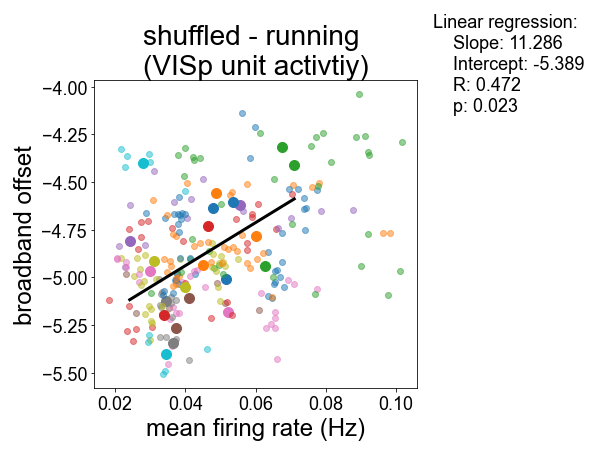

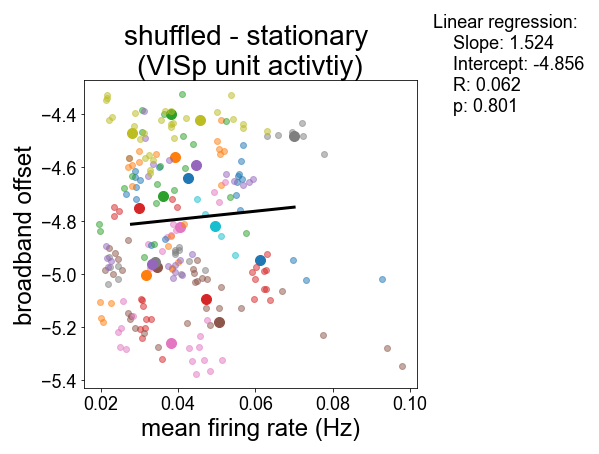

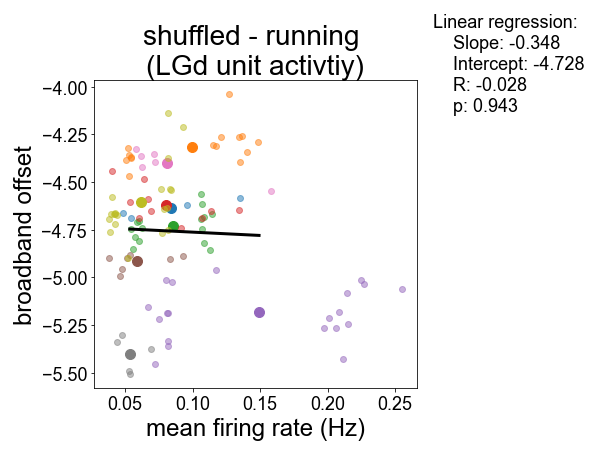

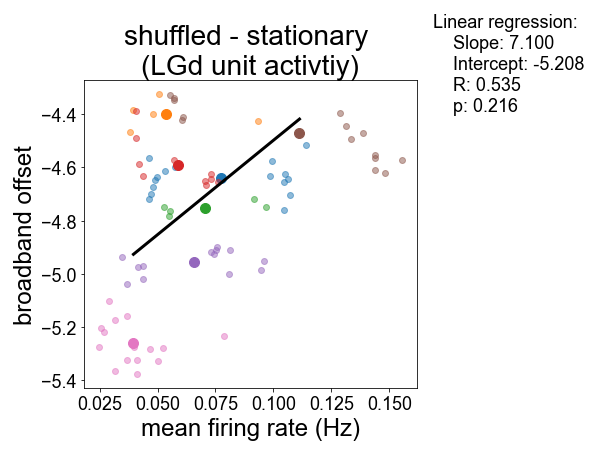

In [17]:
# loop through stimuli
for stimulus, df_lfp, df_units in zip(['movie', 'shuffled'], 
                                      [movie_lfp, shuffled_lfp],
                                      [movie_spikes, shuffled_spikes]):
    # modify df_lfp - average over channels for each epoch within each session
    df_lfp_i = df_lfp.groupby(['session', 'epoch_idx']).mean().reset_index()

    # FIX: remove space from brain structure names
    df_units['brain_structure'] = df_units['brain_structure'].str.replace(' ', '')

    # loop through spiking region
    for spike_region in ['VISp', 'LGd']:
        # get unit data for this region
        df_units_i = df_units[df_units.get("brain_structure")==spike_region]  

        # merge unit and lfp dataframes
        df_i = df_lfp_i.merge(df_units_i, on=['session', 'epoch_idx'])

        # loop through behavioral conditions
        for behavior, running in zip(['running', 'stationary'], [True, False]):

            # filter df by behavior
            df = df_i[df_i.get('running')==running]
            
            # plot each session
            sessions = df.get('session').unique()
            fig, ax = plt.subplots(figsize=(8,6), constrained_layout=True)
            fig.patch.set_facecolor('white')
            for ses in sessions:
                ses_df = df[df.get('session')==ses]

                # plot each epoch
                sc =  ax.scatter(ses_df.get('mean_firing_rate'), 
                                 ses_df.get('offset'), label=ses)

                # plot session mean
                ax.scatter(ses_df.get('mean_firing_rate').mean(), 
                           ses_df.get('offset').mean(), color=sc.get_facecolors()[0], s=100)
                sc.set_alpha(0.5)
                
            # run regression across all epochs and plot results
            df_avg = df.groupby(['session']).mean().reset_index()# average across trials
            x_data = df_avg.get('mean_firing_rate')
            y_data = df_avg.get('offset')
            results = sts.linregress(x_data, y_data)
            l1 = np.linspace(min(x_data), max(x_data), 1000)
            t1 = results.slope * l1 + results.intercept
            ax.plot(l1, t1, color='k', linewidth=3)

            # add regression results text
            if results.pvalue < 0.001:
                pval = f"{results.pvalue:.2e}"
            else:
                pval = f"{results.pvalue:.3f}"
            plt.text(1.05, 0.9, 
                    f"Linear regression:\n" +
                    f"    Slope: {results.slope:.3f}\n" +
                    f"    Intercept: {results.intercept:.3f}\n" +
                    f"    R: {results.rvalue:.3f}\n" +
                    f"    p: {pval}", transform = ax.transAxes)

            # label
            # ax.legend(bbox_to_anchor=(1.05, -.1), loc='lower left', borderaxespad=0.)
            plt.xlabel("mean firing rate (Hz)")
            plt.ylabel("broadband offset")
            plt.title(f"{stimulus} - {behavior} \n({spike_region} unit activtiy)")
            
            # save
            dir_figures = f"{PROJECT_PATH}/figures/offset_vs_rate/{spike_region}/{behavior}"
            # plt.savefig(f"{dir_figures}/all_sessions")

### Regression plot: SPIKE-distance vs. LFP exponent 

##### Spontaneous activity: model behavioral states (running and stationary) seperately  

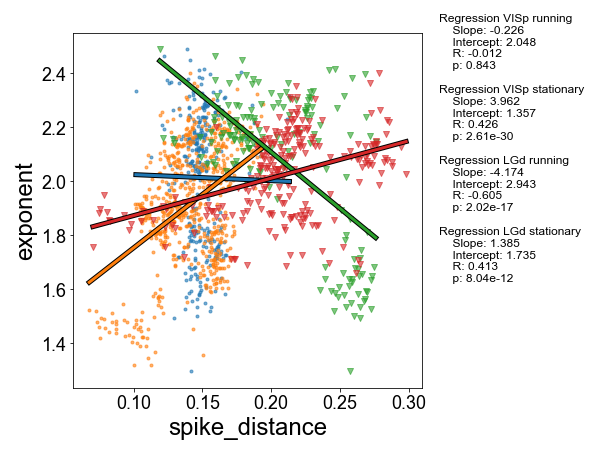

In [18]:
plot_linregress(behavior_df, 'spike_distance', 'exponent', group='behavior', multireg=True, show=True)

##### Passive viewing: model stimulus contexts (movie and shuffled) seperately; plot stationary epochs only

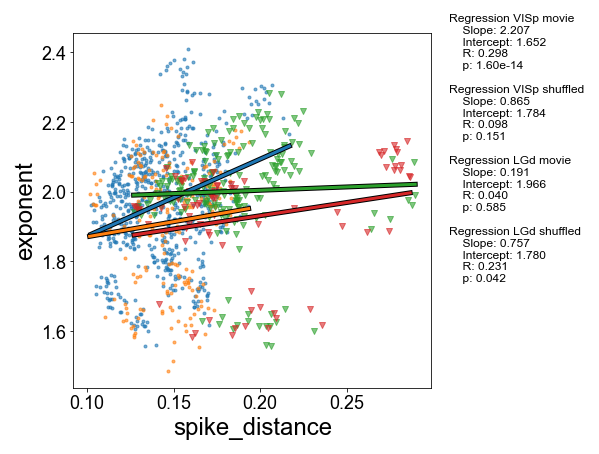

In [19]:
stationary_presentation_df = presentation_df[~presentation_df['running']]
plot_linregress(stationary_presentation_df, 'spike_distance', 'exponent', group='presentation', multireg=True, show=True)

C:\Users\micha\AppData\Roaming\Python\Python37\site-packages\IPython\core\pylabtools.py:151: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)


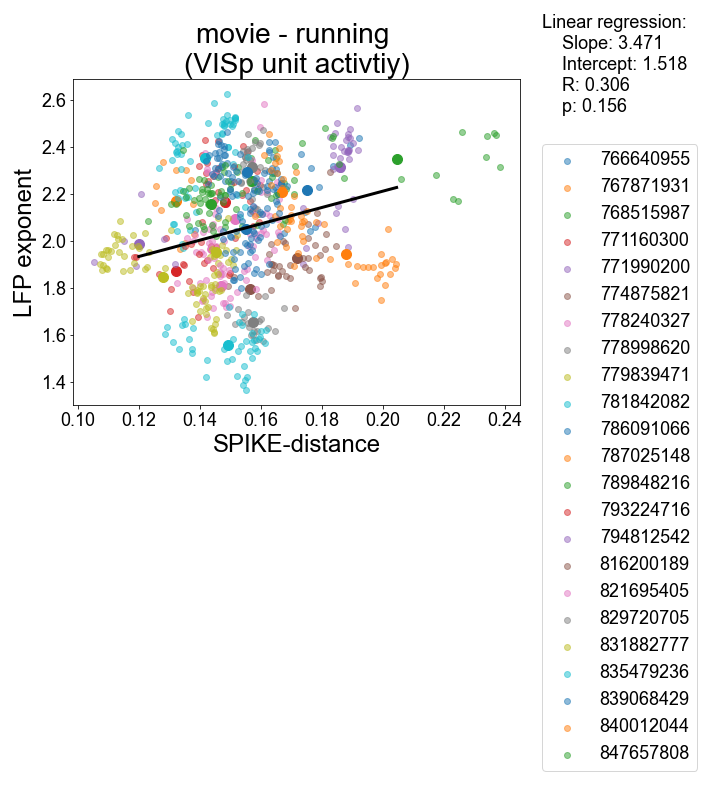

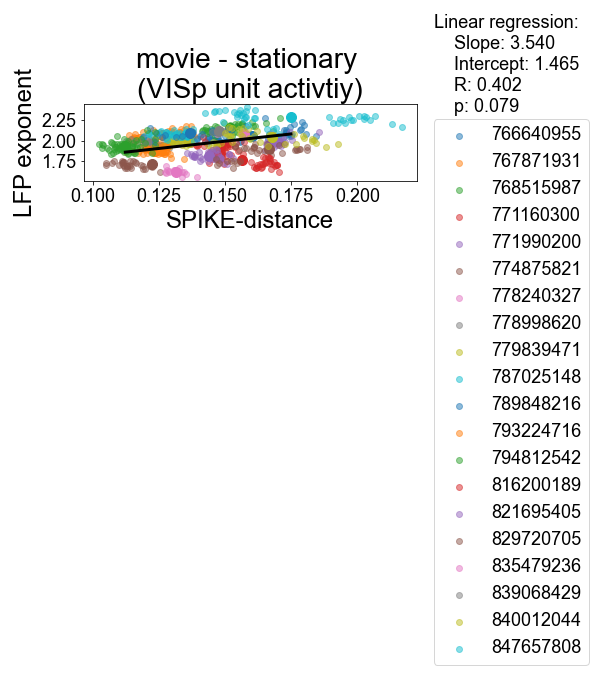

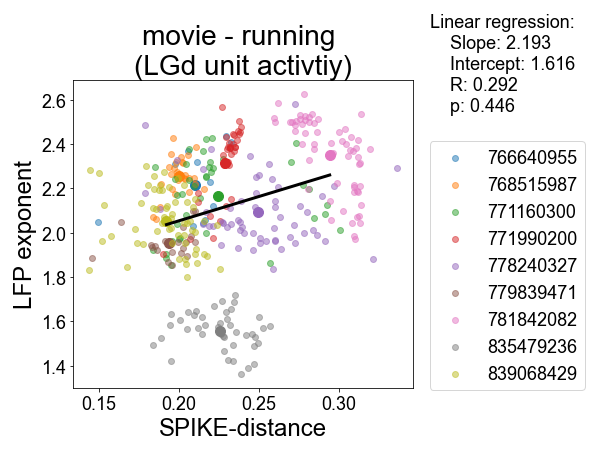

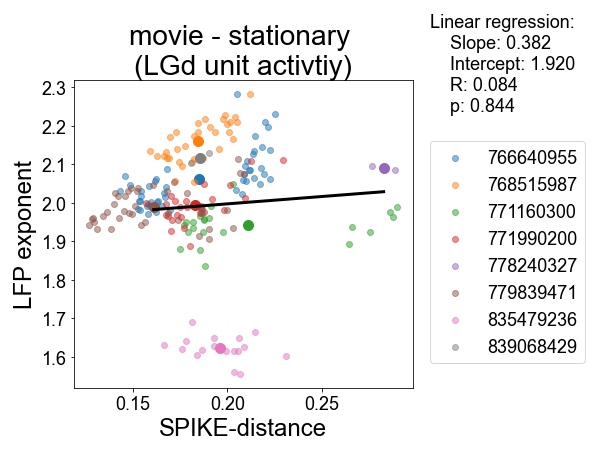

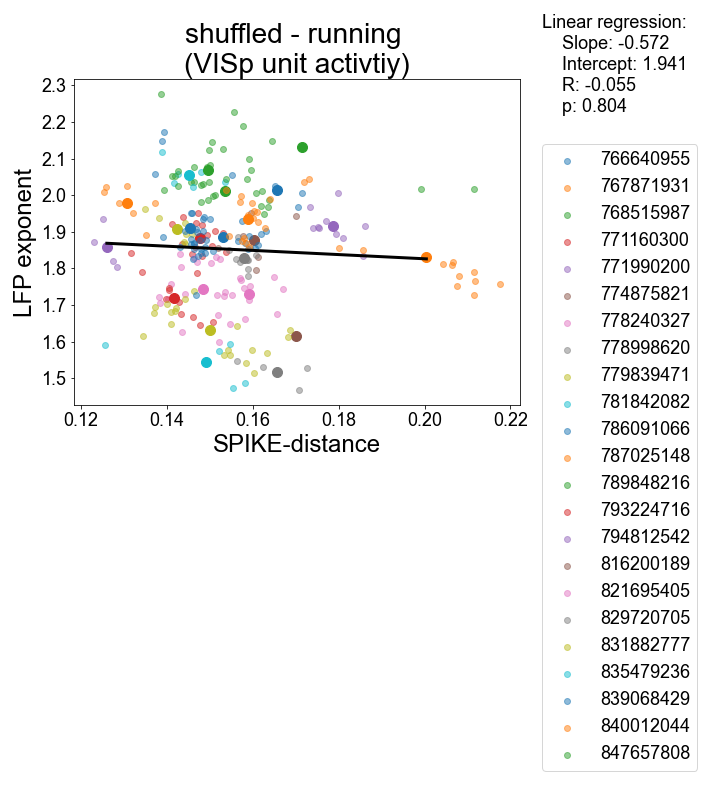

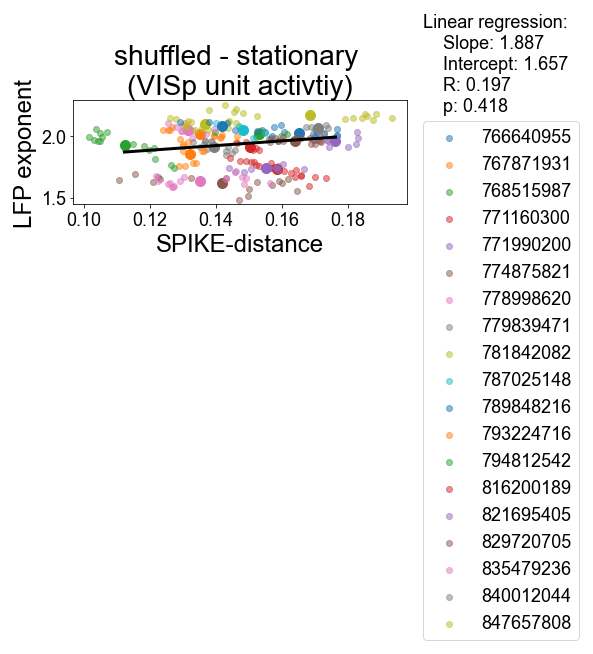

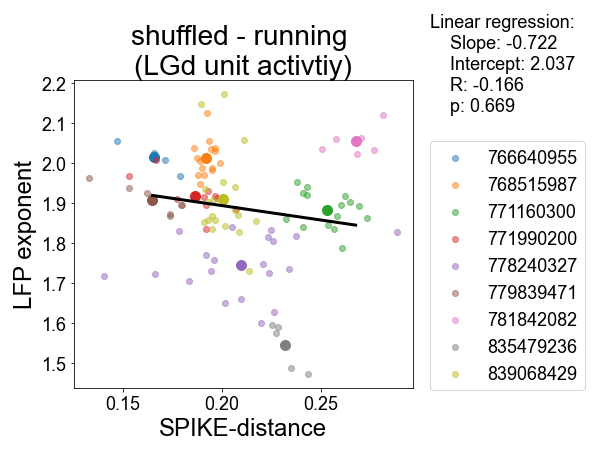

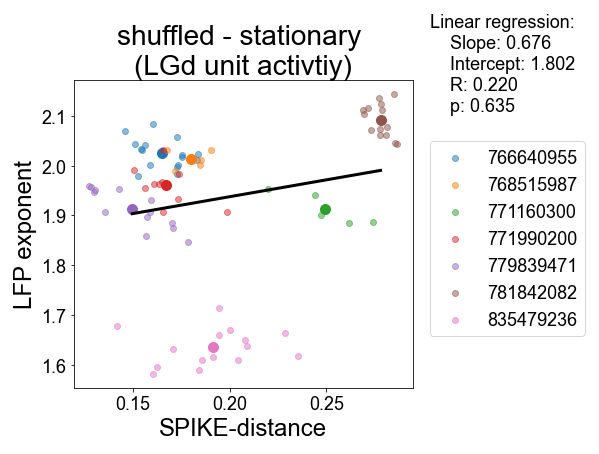

In [20]:
# loop through stimuli
for stimulus, df_lfp, df_units in zip(['movie', 'shuffled'], 
                                      [movie_lfp, shuffled_lfp],
                                      [movie_spikes, shuffled_spikes]):
    # modify df_lfp - average over channels for each epoch within each session
    df_lfp_i = df_lfp.groupby(['session', 'epoch_idx']).mean().reset_index()

    # loop through spiking region
    for spike_region in ['VISp', 'LGd']:
        # get unit data for this region
        df_units_i = df_units[df_units.get("brain_structure")==spike_region]  

        # merge unit and lfp dataframes
        df_i = df_lfp_i.merge(df_units_i, on=['session', 'epoch_idx'])

        # loop through behavioral conditions
        for behavior, running in zip(['running', 'stationary'], [True, False]):

            # filter df by behavior
            df = df_i[df_i.get('running')==running]

            # create figure
            fig, ax = plt.subplots(figsize=(8,6), constrained_layout=True)
            fig.patch.set_facecolor('white')

            # plot each session
            sessions = df.get('session').unique()
            for ses in sessions:
                ses_df = df[df.get('session')==ses]

                # plot each epoch
                sc =  ax.scatter(ses_df.get('spike_distance'), 
                                 ses_df.get('exponent'), label=ses)

                # plot session mean
                ax.scatter(ses_df.get('spike_distance').mean(), 
                           ses_df.get('exponent').mean(), color=sc.get_facecolors()[0], s=100)
                sc.set_alpha(0.5)
                
            # run regression across all epochs and plot results
            df_avg = df.groupby(['session']).mean().reset_index()# average across trials
            x_data = df_avg.get('spike_distance')
            y_data = df_avg.get('exponent')
            results = sts.linregress(x_data, y_data)
            l1 = np.linspace(min(x_data), max(x_data), 1000)
            t1 = results.slope * l1 + results.intercept
            ax.plot(l1, t1, color='k', linewidth=3)

            # add regression results text
            if results.pvalue < 0.001:
                pval = f"{results.pvalue:.2e}"
            else:
                pval = f"{results.pvalue:.3f}"
            plt.text(1.05, 0.9, 
                    f"Linear regression:\n" +
                    f"    Slope: {results.slope:.3f}\n" +
                    f"    Intercept: {results.intercept:.3f}\n" +
                    f"    R: {results.rvalue:.3f}\n" +
                    f"    p: {pval}", transform = ax.transAxes)

            # label
            ax.legend(bbox_to_anchor=(1.05, .8), loc='upper left', borderaxespad=0.)
            plt.xlabel("SPIKE-distance")
            plt.ylabel("LFP exponent")
            plt.title(f"{stimulus} - {behavior} \n({spike_region} unit activtiy)")
            
            # save
            dir_figures = f"{PROJECT_PATH}/figures/exponent_vs_synchrony/{spike_region}/{behavior}"
            # plt.savefig(f"{dir_figures}/all_sessions")

### Statistics

#### Linear mixed effect model

In [28]:
help(mixedLM)

Help on function mixedLM in module allen_vc.stats:

mixedLM(df, var, covariates, group, verbose=True)
    Calculate the results of a Linear Mixed Effect Model.
    
    Parameters
    ----------
    df : pd.DataFrame
        data to be used.
    var : str
        name of dependent variable of interest.
    covariates: list of str
        names of covariates (independent variables / fixed effects).
    group: str
        group labels (random effect).
    verbose: bool
        whether to print results.
    
    Returns
    -------
    results : statsmodels.regression.linear_model.RegressionResultsWrapper
        results of the linear mixed effect model.



In [23]:
# restructure dataframes to inlcude separate columns 
# for VISp and LGd stats to be used as covariates
metrics = ['mean_firing_rate', 'coefficient_of_variation', 'spike_distance', 'spike_synchrony']
long_behavior_df = create_long_region_df(behavior_df, metrics, 'behavior')
long_presentation_df = create_long_region_df(stationary_presentation_df, metrics, 'presentation')

In [29]:
# Run mixedLM: quiescence

stationary_df = long_behavior_df[long_behavior_df['behavior']=='stationary']
covariates = ['VISp_mean_firing_rate', 'LGd_mean_firing_rate', 'VISp_spike_distance', 'LGd_spike_distance']
mixedLM(stationary_df, 'offset', covariates, 'session')
mixedLM(stationary_df, 'exponent', covariates, 'session')

             Mixed Linear Model Regression Results
Model:                MixedLM    Dependent Variable:    offset  
No. Observations:     253        Method:                REML    
No. Groups:           9          Scale:                 0.0189  
Min. group size:      1          Log-Likelihood:        102.1203
Max. group size:      50         Converged:             Yes     
Mean group size:      28.1                                      
----------------------------------------------------------------
                      Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------
VISp_mean_firing_rate 10.133    4.567  2.219 0.027  1.181 19.084
LGd_mean_firing_rate   5.709    1.666  3.427 0.001  2.444  8.975
VISp_spike_distance    8.550    1.645  5.196 0.000  5.325 11.775
LGd_spike_distance    -0.269    0.519 -0.519 0.604 -1.286  0.748
Group Var             40.535  141.924                           

             Mixed Linear Model Regres

In [30]:
# Run mixedLM: movie-watching

mixedLM(long_presentation_df, 'offset', covariates, 'session')
mixedLM(long_presentation_df, 'exponent', covariates, 'session')

             Mixed Linear Model Regression Results
Model:                MixedLM    Dependent Variable:    offset  
No. Observations:     269        Method:                REML    
No. Groups:           9          Scale:                 0.0134  
Min. group size:      2          Log-Likelihood:        153.5647
Max. group size:      65         Converged:             Yes     
Mean group size:      29.9                                      
----------------------------------------------------------------
                      Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------
VISp_mean_firing_rate -1.026    1.089 -0.942 0.346 -3.160  1.109
LGd_mean_firing_rate   0.484    0.599  0.808 0.419 -0.690  1.658
VISp_spike_distance    4.771    1.257  3.794 0.000  2.306  7.235
LGd_spike_distance     1.761    0.394  4.472 0.000  0.989  2.533
Group Var             31.836  131.462                           

             Mixed Linear Model Regres